# Demonstation of the general optimisation problem
which allows for users to specify the combination of assets to be optimised and the relative weights/cost on each
weird combinations/specifications may give weird results (enjoy)

Get stuff ready for optimisation problem
- Load trip data
- specify bus parameters
- predict energy consumption on trips

In [1]:
import time
import copy
import numpy as np
import RouteZero.bus as ebus
from RouteZero.models import PredictionPipe
# %matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.metrics.pairwise import haversine_distances
from RouteZero.map import _create_gdf_of_value, _folium_open, _create_gdf_map
from RouteZero.models import summarise_results
from RouteZero.route import calc_buses_in_traffic
from RouteZero.optim import Extended_feas_problem, plot_results, determine_charger_use
from RouteZero.optim import General_problem

RESOLUTION = 10  # mins
MIN_CHARGE_TIME = 1 * 60  # mins
RESERVE = 0.2  # percent of all battery to keep in reserve [0-1]
DEADHEAD = 0.1
START_CHARGE = FINAL_CHARGE = 0.9

Some default parameters that we may wish to adjust

In [2]:

busy_routes_only = True
busy_routes_only = False
NUM_ROUTES = 40

# region = 1          # all NSW     (used 67.5 terrawatt hours last financial year, so the bus load seems negigible?)
# region = 2          # all Victoria
# region = 3          # metro melbourne (vic)
# region = 4          # Sydney    (radius bounded)
# region = 5          # all tasmania
# region = 6          # Perth
# region = 7          # darwin
region = 8          # all ACT
region = 8.1          # Belconnen in ACT
# region = 9          # all SEQ (brisbane, gold coast, sunshien coast)
# region = 10          # Adelaide
# region = 11          # Newcastle

if region==1:
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/greater_sydney/shapes.shp')
elif region==2:
    trips_data_1 = pd.read_csv('../data/gtfs/vic_metro_bus/trip_data.csv')
    trips_data_2 = pd.read_csv('../data/gtfs/vic_regional_bus/trip_data.csv')
    trips_data = pd.concat([trips_data_1, trips_data_2])
elif region==3:
    trips_data = pd.read_csv('../data/gtfs/vic_metro_bus/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/vic_metro_bus/shapes.shp')
elif region==4:
    # routes within 30km of fairfield (roughly middle of the sydney regions?)
    # agencies = ["Transit Systems"]
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv')
    X = np.vstack([trips_data["start_loc_y"].to_numpy(), trips_data["start_loc_x"].to_numpy()]).T
    # sydney_gps = np.deg2rad([-33.8688, 151.2093]).reshape((1,2))
    sydney_gps = np.deg2rad([-33.8666632, 150.916663]).reshape((1,2))  # fairfield coordinates as its more in the middle
    X = np.deg2rad(X)
    d = haversine_distances(X, Y=sydney_gps)* 6371000/1000
    trips_data = trips_data[d <= 30]
    shapes = gpd.read_file('../data/gtfs/greater_sydney/shapes.shp')
elif region==5:
    trips_data_1 = pd.read_csv('../data/gtfs/Tas_burnie/trip_data.csv')
    trips_data_2 = pd.read_csv('../data/gtfs/Tas_hobart/trip_data.csv')
    trips_data_3 = pd.read_csv('../data/gtfs/Tas_launceston/trip_data.csv')
    trips_data = pd.concat([trips_data_1, trips_data_2, trips_data_3])
elif region==6:
    trips_data = pd.read_csv('../data/gtfs/perth/trip_data.csv')
    trips_data = trips_data[trips_data["agency_name"]=="Transperth"]
    shapes = gpd.read_file('../data/gtfs/perth/shapes.shp')
elif region == 7:
    trips_data = pd.read_csv('../data/gtfs/darwin/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/darwin/shapes.shp')
elif region == 8:
    trips_data = pd.read_csv('../data/gtfs/act/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/act/shapes.shp')
elif region == 8.1:
    trips_data = pd.read_csv('../data/gtfs/act/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/act/shapes.shp')
    route_names = [2,3,8,9,23,24,30, 31, 32, 40, 41, 42, 43, 44, 45, 46, 47, 901, 903]
    trips_data = trips_data[trips_data["route_short_name"].isin(route_names)]
elif region == 9:
    trips_data = pd.read_csv('../data/gtfs/brisbane/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/brisbane/shapes.shp')
elif region == 10:
    trips_data = pd.read_csv('../data/gtfs/adelaide/trip_data.csv')
    shapes = gpd.read_file('../data/gtfs/adelaide/shapes.shp')
elif region==11:
    trips_data = pd.read_csv('../data/gtfs/greater_sydney/trip_data.csv', index_col='Unnamed: 0')
    trips_data = trips_data[trips_data['agency_name']=='Newcastle Transport']
else:
    print("Invalid region selected")

if busy_routes_only:
    test = trips_data.groupby(by=['route_short_name'])["route_short_name"].count().sort_values()
    route_names = test.index[-NUM_ROUTES:]
    print(route_names)
    trips_data = trips_data[trips_data["route_short_name"].isin(route_names)]
    print("number of trips is",len(trips_data))


Start specifying the assets we wish to consider and which ones we would like to optimise
First, set the grid limit or choose to optimise it

If set to 'optim' attempts to minimise the grid limit using the relative weighting of Q

In [3]:
def plot_study_results(results, problem):
    grid_limit = results['grid_limit']
    # optim_chargers = results['chargers']
    battery_power = results['battery_action']
    charging_power = results['charging_power']
    total_energy_avail = results['total_energy_available']
    # battery_soc = results['battery_soc']
    aggregate_power = results['aggregate_power']
    chargers = results['chargers']
    battery_soc = results["battery_soc"]
    # battery_spec = results['battery_spec']
    times = problem.times

    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(times / 60, charging_power, label='combined bus charging')
    plt.plot(times / 60, aggregate_power, label='power from grid', linestyle='-.')
    plt.plot(times / 60, battery_power, label='battery power')
    plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
    plt.title('Depot power')
    plt.xlabel('Hour of week')
    plt.ylabel('Power (kW)')
    plt.xlim([0, times[-1] / 60])
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(times / 60, total_energy_avail, label="combined bus battery")
    plt.plot(times / 60, battery_soc, label = "on-site battery")
    plt.axhline(problem.final_charge * problem.num_buses * problem.bus_capacity, linestyle='--', color='k',
                label='required end bus SOC')
    plt.axhline(problem.reserve_energy, linestyle='--', color='r', label='bus reserve')
    plt.xlabel('Hour of week')
    plt.ylabel('Energy available (kWh)')
    plt.title('Battery capacities')
    plt.xlim([0, times[-1] / 60])
    plt.ylim([0, problem.num_buses * problem.bus_capacity])
    plt.legend()

    chargers_in_use = determine_charger_use(chargers,problem.Nt_avail, charging_power, problem.windows)
    r, c = chargers_in_use.shape
    plt.subplot(3, 1, 3)
    plt.plot(times / 60, chargers_in_use[:, 0])
    plt.xlabel('Hour of week')
    plt.ylabel('# chargers'.format(chargers['power'][0]))
    plt.title("Number of bus chargers in use")
    plt.xlim([0, times[-1] / 60])

    plt.tight_layout()
    plt.show()


Specify charger sets, this is done as a list of powers, numbers, and costs,
where number[i] is the number of chargers with power[i] and can be set to 'optim' to allow this to be optimised, in
which case cost[i] is the relative cost on that number.
All lists must be same length, so cost is provided even if not optimised (will be ignored)

If set to 'optim' attempts to minimise the number using the relative weighting of 'cost'

min requried buses =  85


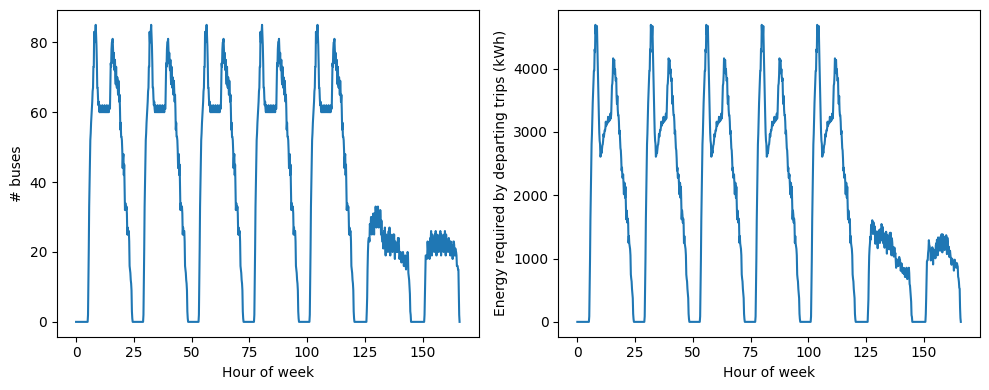

In [4]:

trips_data['passengers'] = 30

bus = ebus.Yutong()

# from RouteZero.bus import Bus as Ebus
# max_passengers = 70
# battery_capacity = 400      # kWh
# charging_rate = 200         # kW
# gross_mass = 18000          # kg

# # default parameters that they could optionally change
# charging_efficiency=0.9
# end_of_life_cap=0.8

# bus = Ebus(max_passengers, battery_capacity, charging_rate, gross_mass,
#               charging_efficiency=charging_efficiency, end_of_life_cap=end_of_life_cap)

prediction_pipe = PredictionPipe()

ec_km, ec_total = prediction_pipe.predict_worst_case(trips_data, bus)

times, buses_in_traffic, depart_trip_energy_reqs, return_trip_enery_consumed = calc_buses_in_traffic(trips_data,
                                                                                                     deadhead=DEADHEAD,
                                                                                                     resolution=RESOLUTION,
                                                                                                     trip_ec=ec_total)
t = np.cumsum(depart_trip_energy_reqs) - np.cumsum(return_trip_enery_consumed)
print("min requried buses = ", buses_in_traffic.max())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(times / 60, buses_in_traffic)
plt.xlabel('Hour of week')
plt.ylabel('# buses')

plt.subplot(1, 2, 2)
# plt.plot(times / 60, depart_trip_energy_reqs)
plt.plot(times/60, t)
# plt.plot(times/60, return_trip_enery_consumed, label="returning trips")
plt.xlabel("Hour of week")
plt.ylabel("Energy required by departing trips (kWh)")

plt.tight_layout()
# plt.show()



In [5]:
# plot on map
route_summaries = summarise_results(trips_data, ec_km, ec_total)

gdf = _create_gdf_of_value(route_summaries, shapes, window='6:00 - 9:30')

map_title = "Route Energy Consumption"
colorbar_str = 'energy per km'

m = _create_gdf_map(gdf, map_title, colorbar_str)
_folium_open(m, map_title + '.html')

In [7]:
grid_limit = 'optim'
# grid_limit = 3500
Q = 10000    # relative cost on grid limit, set to 0 if no cost

Specify a priority on keeping the bus batteries charged at all times. Priority specified by R.

Note, this cost conflicts with the others as it attempts to maximise the battery charge (i.e. acts against other objectives). Hence the relative weighting of R with respect to the other weightings/costs will greatly impact the results and there will be a fine line between it doing nothing and overriding the other objectives.

In [8]:
R = 0       # priority on bus charge

Specify battery if we would like to include one. If we would like to optimise the battery capacity, then set to 'optim'. 'cost' is the relative weighting on the battery capacity. 'cost' must be provided either way.

If set to 'optim' attempts to minimise the capacity using the relative weighting of 'cost'

In [18]:
battery = {'power':2000, 'capacity':4000, 'efficiency':0.95, 'cost':10}
# battery = {'power':1000, 'capacity':'optim', 'efficiency':0.95, 'cost':100}
battery_specs = copy.deepcopy(battery)
no_battery = {'power':0, 'capacity':0, 'efficiency':0.95, 'cost':10}
no_battery_specs = copy.deepcopy(no_battery)

Chargers

In [10]:
charger_power_array = [80, 150, 300] 
charger_cost_array = [1, 5, 20]
chargers = {'power': charger_power_array, 
            'number': ["optim", "optim", "optim"], 
            'cost': charger_cost_array}
charger_specs = copy.deepcopy(chargers)

Specified allowed times of day to charge (which hours), default is all

In [11]:
all_times = [1]*7 + [1]*3 + [1]*5 + [1]*5 + [1]*4     # all times ok
off_peak = [1]*6 + [0]*4 + [1]*6 + [0]*7 + [1]*1     # peak times not allowed

Set up the problem and optimise

In [38]:
battery = copy.deepcopy(battery_specs)
problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=all_times)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

Solve took 60.59884071350098 seconds


Plot results

Max grid power is 2626.1971 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([12.,  0.,  0.]), 'cost': [20, 5, 1]}
{'power': 2000, 'capacity': 4000, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 0.0 %


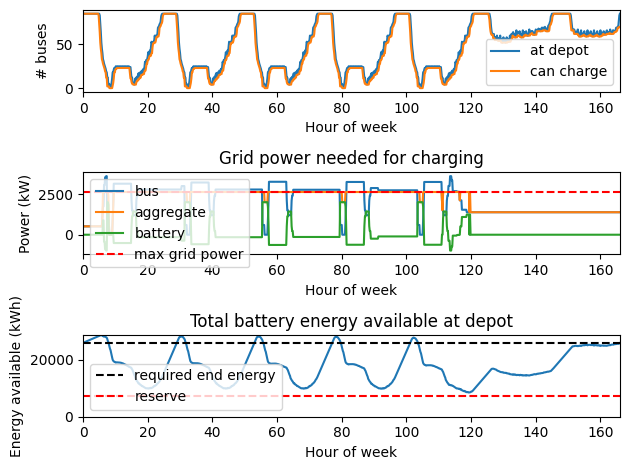

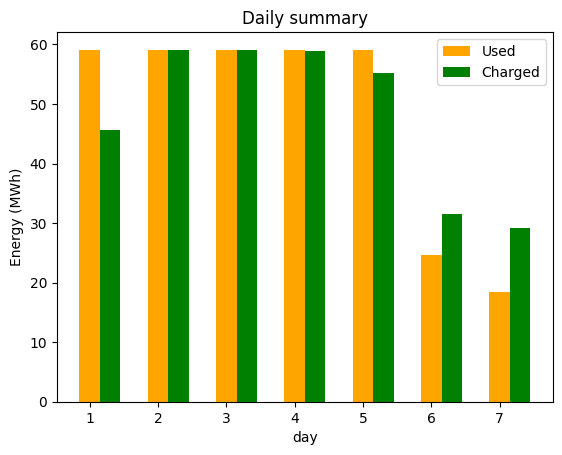

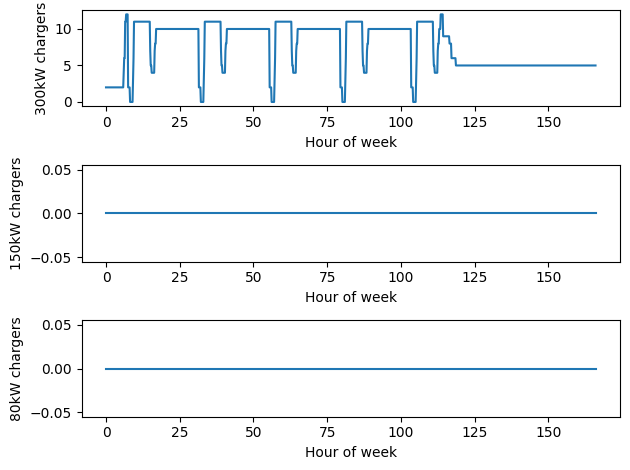

In [39]:
chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)

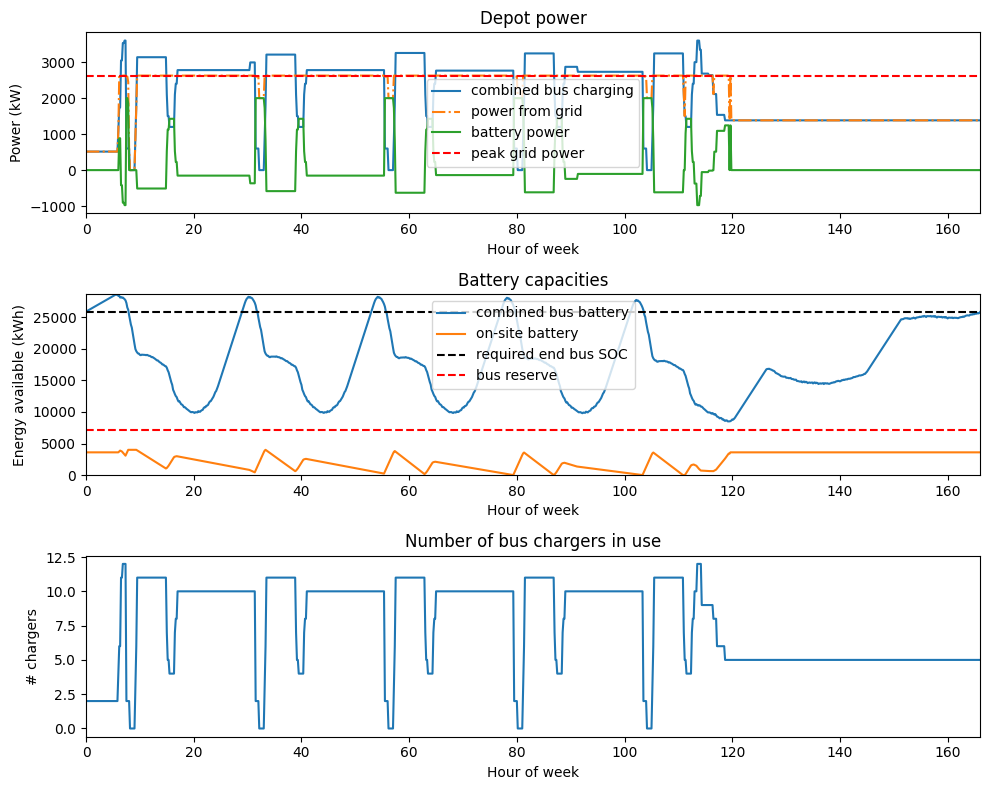

In [40]:
plot_study_results(results, problem)

Reference case without depot battery, leaving everything else the same

Solve took 40.481385231018066 seconds
Max grid power is 3101.0055 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([10.,  1.,  0.]), 'cost': [20, 5, 1]}
{'power': 0, 'capacity': 0, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 0.0 %


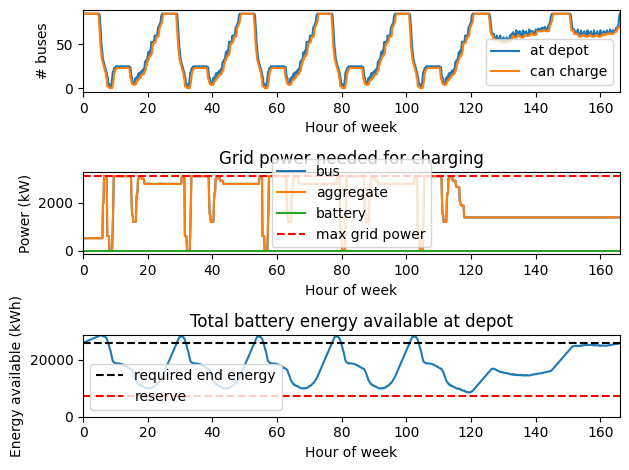

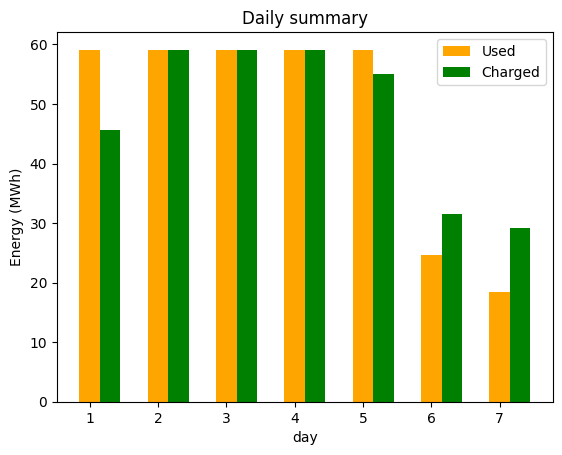

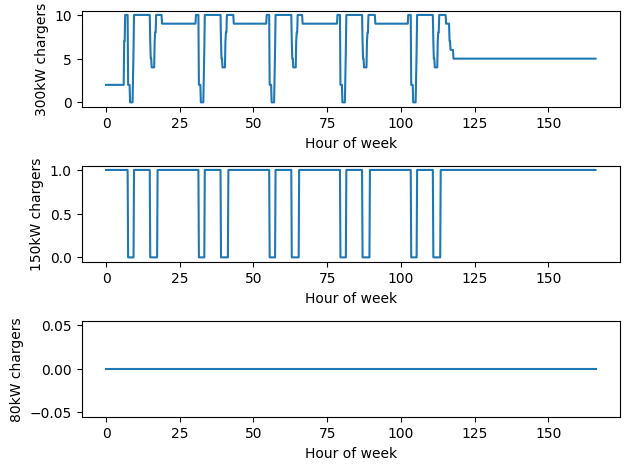

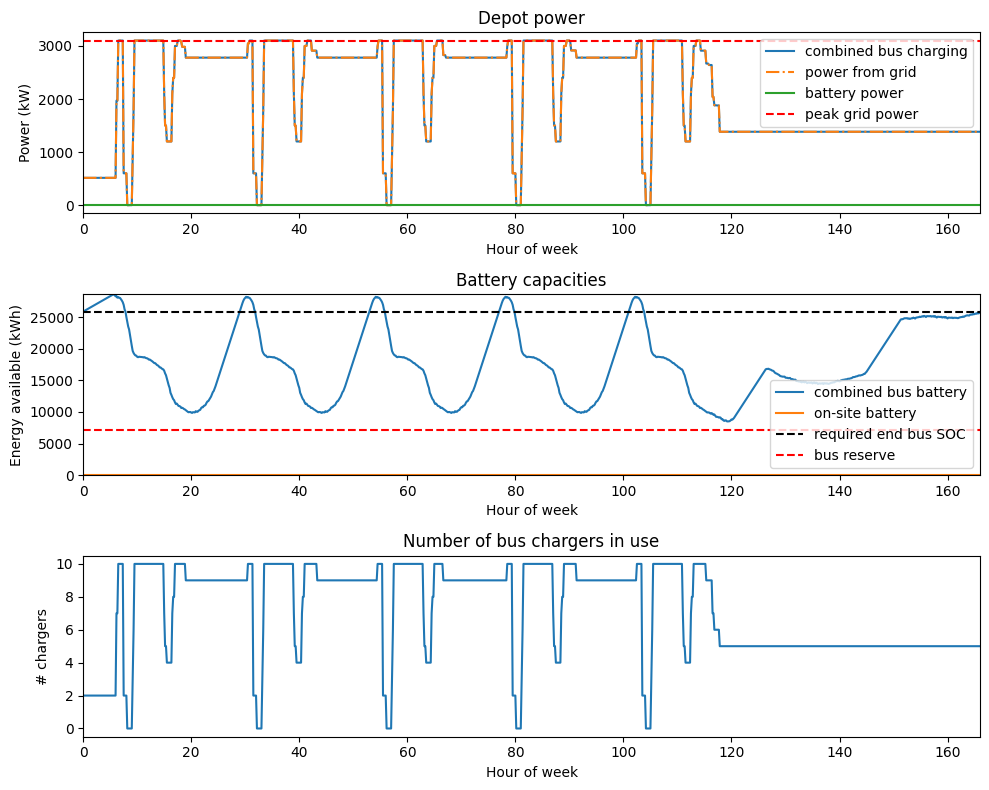

In [56]:

battery = copy.deepcopy(no_battery_specs)
chargers = copy.deepcopy(charger_specs)

problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=all_times)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)
plot_study_results(results, problem)

Reference case, no battery, off peak only charging

Solve took 31.065128087997437 seconds
Max grid power is 6011.1111 kW
Optimised charger configuration is: 
{'power': [300, 150, 80], 'number': array([23.,  0.,  0.]), 'cost': [20, 5, 1]}
{'power': 2000, 'capacity': 4000, 'efficiency': 0.95, 'cost': 10}
Unable to achieve desired final charge by 16.287003415110117 %


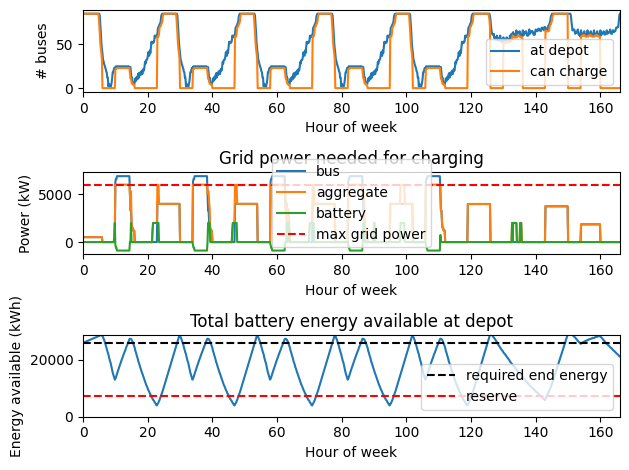

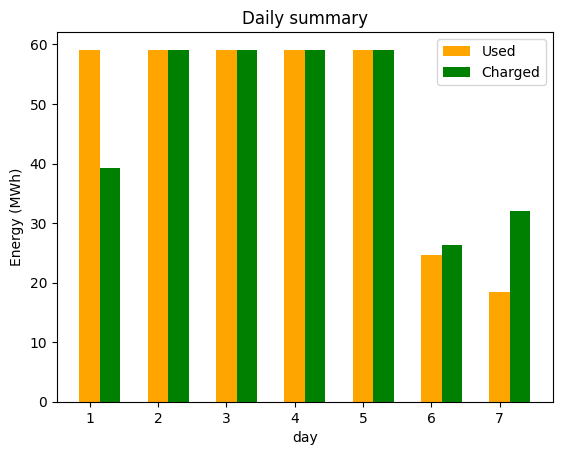

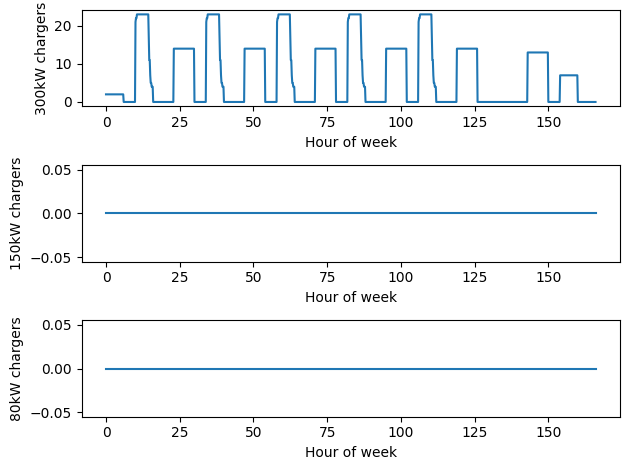

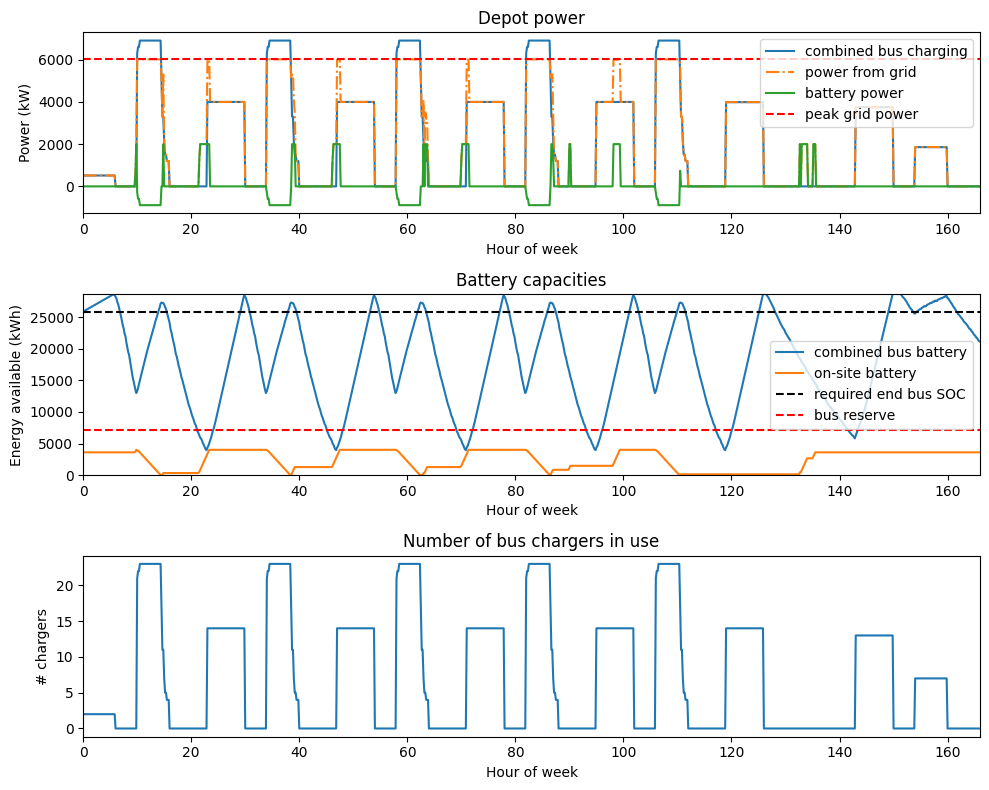

In [42]:
battery = copy.deepcopy(no_battery_specs)
chargers = copy.deepcopy(charger_specs)

problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=off_peak)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)
plot_study_results(results, problem)

Reference case, battery, off peak

In [ ]:
battery = copy.deepcopy(battery_specs)
chargers = copy.deepcopy(charger_specs)

problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, windows=off_peak)

t1 = time.time()
results = problem.solve()
t2 = time.time()

print('Solve took {} seconds'.format(t2 - t1))

chargers_results = results['chargers']
charging_power = results['charging_power']
total_energy_avail = results['total_energy_available']
battery_soc = results['battery_soc']
aggregate_power = results['aggregate_power']
battery_power = results['battery_action']
times = problem.times

print('Max grid power is {} kW'.format(results['grid_limit']))
print('Optimised charger configuration is: ')
print(chargers_results)
print(results["battery_spec"])
print('Unable to achieve desired final charge by {} %'.format(results['final_soc_infeas_%']))

plot_results(results, problem)
plot_study_results(results, problem)

### Now investigate the effects of extra buses, chargers and depot batteries on peak power demand

Scan number of buses, charging at all times

In [14]:
num_chargers_scans_300 = 12

In [12]:
nu_buses = 16
min_bus = 85
max_bus = 100


t1 = time.time()
scan_bus_peak_demands = []
scan_bus_chargers_required = []

Q = 10000
for num_bus in np.linspace(min_bus, max_bus, nu_buses):
    chargers = {'power': charger_power_array, 
            'number': ["optim", "optim", "optim"], 
            'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=all_times)
    
    results = problem.solve()
    
    scan_bus_peak_demands.append(results['grid_limit'])
    scan_bus_chargers_required.append(chargers['number'])

print(scan_bus_peak_demands)
print(scan_bus_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[2626.1971, 2568.5075, 2544.5433]
[array([12.,  0.,  0.]), array([14.,  0.,  0.]), array([14.,  1.,  1.])]
Solve took 354.20690298080444 seconds


Scan number of buses, charging outside peak times

In [15]:


t1 = time.time()
scan_bus_peak_demands_offpeak = []
scan_bus_chargers_required_offpeak = []
Q = 10000
for num_bus in np.linspace(min_bus, max_bus, nu_buses):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_bus,
                          windows=off_peak)
    
    results = problem.solve()
    
    scan_bus_peak_demands_offpeak.append(results['grid_limit'])
    scan_bus_chargers_required_offpeak.append(chargers['number'])

print(scan_bus_peak_demands_offpeak)
print(scan_bus_chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[4516.9184, 4683.3333, 4983.3333]
[array([12., 11.,  0.]), array([12., 13.,  0.]), array([12., 15.,  0.])]
Solve took 98.72078514099121 seconds


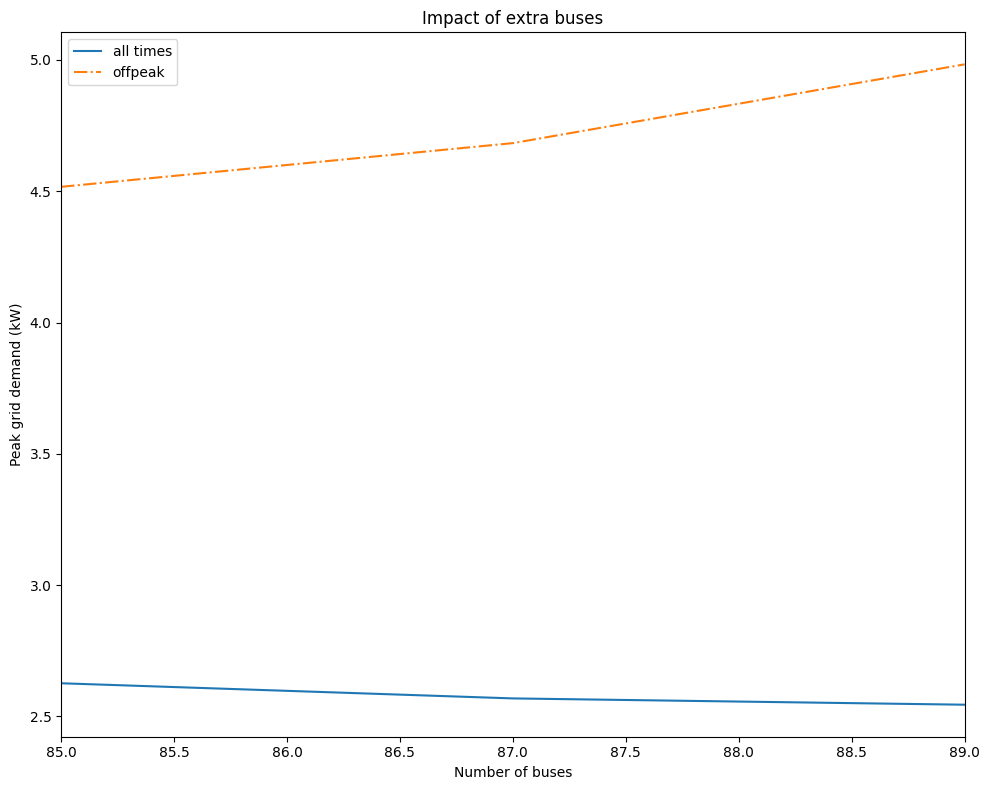

In [16]:
x_data = np.linspace(min_bus,max_bus,nu_buses)
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
plt.plot(x_data, np.array(scan_bus_peak_demands)/1000, label='all times')
plt.plot(x_data, np.array(scan_bus_peak_demands_offpeak)/1000, label='offpeak', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of extra buses')
plt.xlabel('Number of buses')
plt.ylabel('Peak grid demand (kW)')
plt.xlim([x_data[0], x_data[-1]])
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
num_buses_scans = 85 + 2

Scan number of chargers, charging at all times

In [46]:
nu_chargers = 9
min_charger = 12
max_charger = 20

t1 = time.time()
scan_charger_peak_demands = []
scan_charger_chargers_required = []
Q = 10000
for c in np.linspace(min_charger,max_charger,nu_chargers):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", int(c)], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                          windows=all_times)
    
    results = problem.solve()
    
    scan_charger_peak_demands.append(results['grid_limit'])
    scan_charger_chargers_required.append(chargers['number'])

print(scan_charger_peak_demands)
print(scan_charger_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[2166.7513, 2166.7513, 2166.7513, 2166.7513, 2166.7513, 2166.7513, 2166.7513, 2166.7513, 2166.7513, 2166.7513, 2166.7513]
[array([68.,  0.,  0.]), array([72.,  0.,  0.]), array([76.,  0.,  0.]), array([80.,  0.,  0.]), array([84.,  0.,  0.]), array([88.,  0.,  0.]), array([92.,  0.,  0.]), array([96.,  0.,  0.]), array([100.,   0.,   0.]), array([104.,   0.,   0.]), array([108.,   0.,   0.])]
Solve took 878.3366651535034 seconds


Scan number of chargers, charging outside peak times

In [47]:

t1 = time.time()
scan_charger_peak_demands_offpeak = []
scan_charger_chargers_required_offpeak = []
Q = 10000
for c in np.linspace(min_charger,max_charger,nu_chargers):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", int(c)], 
                'cost': charger_cost_array}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                          windows=off_peak)
    
    results = problem.solve()
    
    scan_charger_peak_demands_offpeak.append(results['grid_limit'])
    scan_charger_chargers_required_offpeak.append(chargers['number'])

print(scan_charger_peak_demands_offpeak)
print(scan_charger_chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[3569.1174, 3569.1174, 3569.1174, 3569.1174, 3569.1174, 3569.1174, 3569.1174, 3569.1174, 3569.1174, 3569.1174, 3569.1174]
[array([68.,  0.,  0.]), array([72.,  0.,  0.]), array([76.,  0.,  0.]), array([80.,  0.,  0.]), array([84.,  0.,  0.]), array([88.,  0.,  0.]), array([92.,  0.,  0.]), array([96.,  0.,  0.]), array([100.,   0.,   0.]), array([104.,   0.,   0.]), array([108.,   0.,   0.])]
Solve took 360.0230824947357 seconds


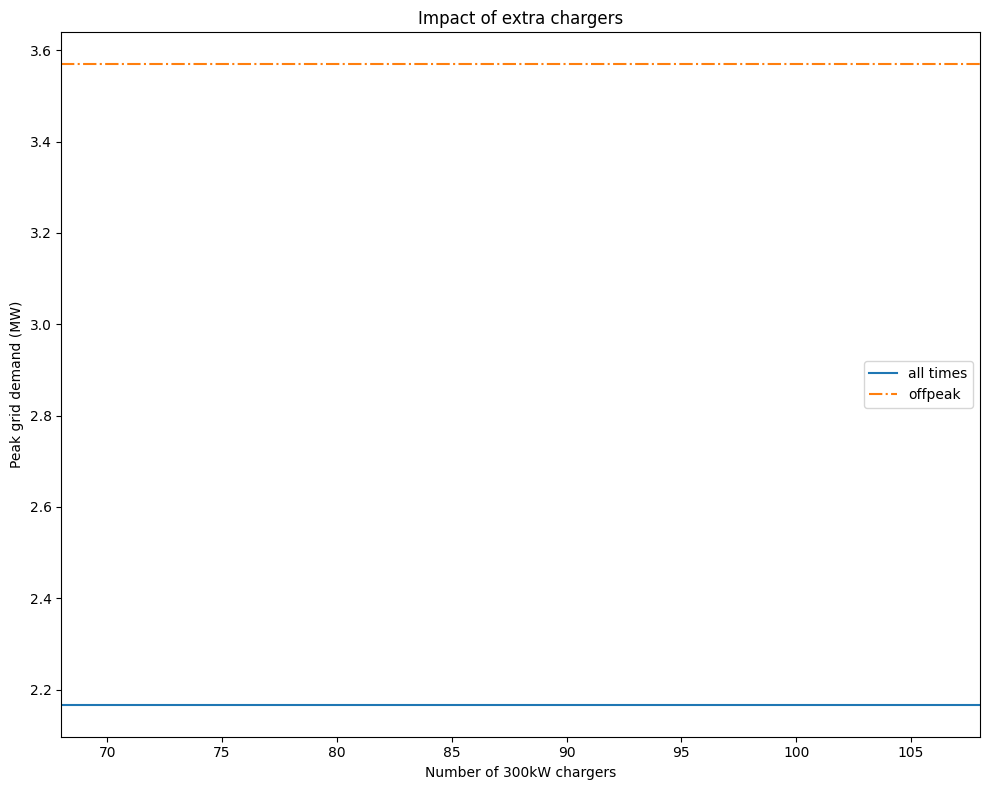

In [48]:
x_data = np.linspace(min_charger,max_charger,nu_chargers)
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
plt.plot(x_data, np.array(scan_charger_peak_demands)/1000, label='all times')
plt.plot(x_data, np.array(scan_charger_peak_demands_offpeak)/1000, label='offpeak', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of extra chargers')
plt.xlabel('Number of 300kW chargers')
plt.ylabel('Peak grid demand (MW)')
plt.xlim([x_data[0], x_data[-1]])
plt.legend()

plt.tight_layout()
plt.show()

Scan battery capacities, charging at all times

In [20]:
nu_batteries = 9
min_battery = 0
max_battery = 4


t1 = time.time()
scan_battery_peak_demands = []
scan_battery_chargers_required = []
Q = 10000
batt_c_rating = 2
for batt_p in np.linspace(min_battery,max_battery,nu_batteries):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}
    
    battery = {'power':batt_p, 'capacity':batt_p*batt_c_rating, 'efficiency':0.95, 'cost':10}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                          windows=all_times)
    
    results = problem.solve()
    
    scan_battery_peak_demands.append(results['grid_limit'])
    scan_battery_chargers_required.append(chargers['number'])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[2787.5573, 2787.1674, 2786.7776]
[array([9., 1., 0.]), array([9., 1., 0.]), array([9., 1., 0.])]
Solve took 200.76154732704163 seconds


Scan battery capacities, charging outside peak times

In [50]:

t1 = time.time()
scan_battery_peak_demands_offpeak = []
chargers_required_offpeak = []
Q = 10000
batt_c_rating = 2
for batt_p in np.linspace(min_battery,max_battery,nu_batteries):
    chargers = {'power': charger_power_array, 
                'number': ["optim", "optim", "optim"], 
                'cost': charger_cost_array}
    
    battery = {'power':batt_p, 'capacity':batt_p*batt_c_rating, 'efficiency':0.95, 'cost':10}

    problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                          start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                          resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                          reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                          windows=off_peak)
    
    results = problem.solve()
    
    scan_battery_peak_demands_offpeak.append(results['grid_limit'])
    chargers_required_offpeak.append(chargers['number'])

print(scan_battery_peak_demands_offpeak)
print(chargers_required_offpeak)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

[4158.7726, 4011.3588, 3863.945, 3716.5312, 3569.1174, 3421.7036, 3274.2898, 3126.876, 2979.4623, 2832.0485, 2684.6347, 2608.4872, 2542.9157, 2477.3442, 2411.7726, 2346.2011, 2317.2889, 2316.6519, 2316.0149, 2315.3779, 2314.7408]
[array([ 0.,  0., 52.]), array([ 0.,  0., 53.]), array([ 0.,  0., 53.]), array([ 0.,  0., 53.]), array([ 0.,  0., 53.]), array([ 0.,  0., 53.]), array([ 0.,  0., 53.]), array([ 0.,  0., 53.]), array([ 0.,  0., 54.]), array([ 0.,  0., 54.]), array([ 0.,  0., 54.]), array([ 0.,  0., 55.]), array([ 0.,  0., 56.]), array([ 0.,  0., 57.]), array([ 0.,  0., 58.]), array([ 0.,  0., 60.]), array([ 0.,  0., 60.]), array([ 0.,  0., 60.]), array([ 0.,  0., 60.]), array([ 0.,  0., 60.]), array([ 0.,  0., 60.])]
Solve took 847.9720113277435 seconds


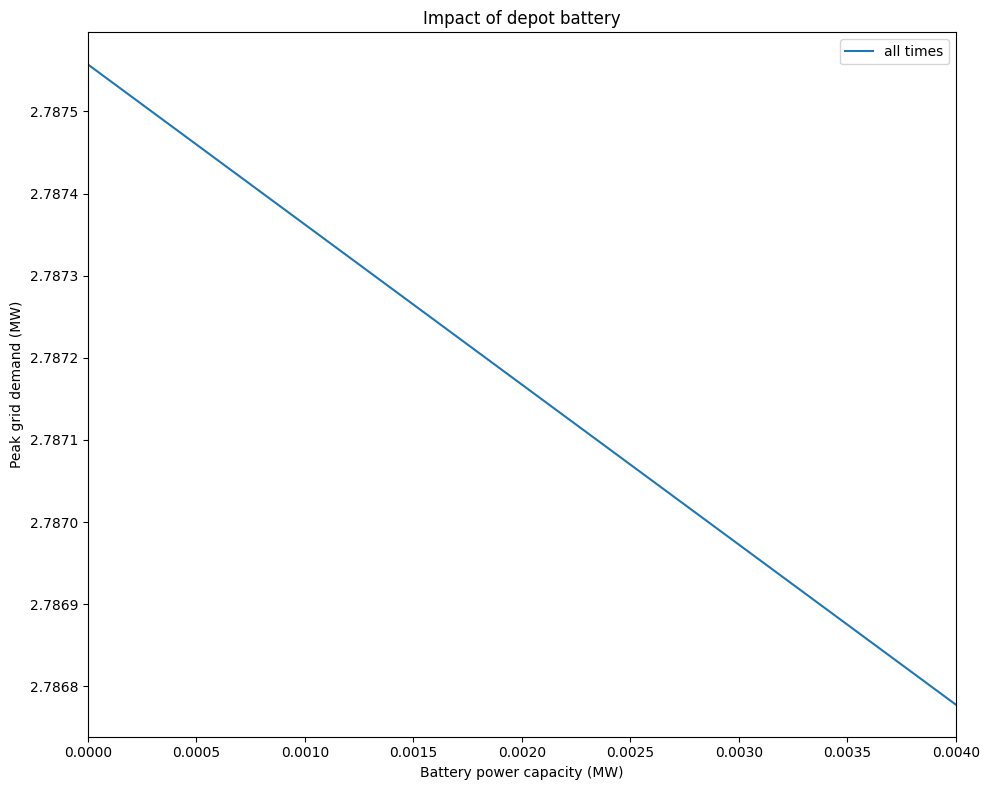

In [21]:
x_data = np.linspace(min_battery/1000,max_battery/1000,nu_batteries)
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
plt.plot(x_data, np.array(scan_battery_peak_demands)/1000, label='all times')
# plt.plot(x_data, np.array(scan_battery_peak_demands_offpeak)/1000, label='offpeak', linestyle='-.')
# plt.axhline(grid_limit, linestyle='--', color='r', label='peak grid power')
plt.title('Impact of depot battery')
plt.xlabel('Battery power capacity (MW)')
plt.ylabel('Peak grid demand (MW)')
plt.xlim([x_data[0], x_data[-1]])
plt.legend()

plt.tight_layout()
plt.show()



In [52]:
nu_battery_powers = 11
min_battery_p = 0
max_battery_p = 5 #MW
batt_ps = np.linspace(min_battery_p,max_battery_p,nu_battery_powers)
nu_battery_capacities = 21
min_battery_c = 0
max_battery_c = 10 #MW
batt_cs = np.linspace(min_battery_c,max_battery_c,nu_battery_capacities)

t1 = time.time()
scan_battery_peak_demands = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_300 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_150 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_80 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
Q = 10000
for batt_p in batt_ps:
    for batt_c in batt_cs:
        chargers = {'power': charger_power_array, 
                    'number': ["optim", "optim", "optim"], 
                    'cost': charger_cost_array}
        
        battery = {'power':batt_p*1000, 'capacity':batt_c*1000, 'efficiency':0.95, 'cost':10}

        problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                            start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                            resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                            reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                            windows=all_times)
        
        results = problem.solve()
        
        scan_battery_peak_demands.loc[batt_p, batt_c] = float(results['grid_limit'])
        scan_battery_chargers_required_80.loc[batt_p, batt_c] = float(chargers['number'][0])
        scan_battery_chargers_required_150.loc[batt_p, batt_c] = float(chargers['number'][1])
        scan_battery_chargers_required_300.loc[batt_p, batt_c] = float(chargers['number'][2])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

           0.0        2.5        5.0        7.5        10.0       12.5  \
0.0   2169.1312  2169.1312  2169.1312  2169.1312  2169.1312  2169.1312   
1.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
2.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
3.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
4.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
5.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
6.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
7.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
8.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
9.0   2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   
10.0  2169.1312  2167.6438  2166.1563  2164.6688  2163.1813  2161.6939   

           15.0       17.5       20.0       22.5  ...       27.5       30.0  \
0.0   2169.1312  2169.1312  2169

Text(0, 0.5, 'Number of chargers')

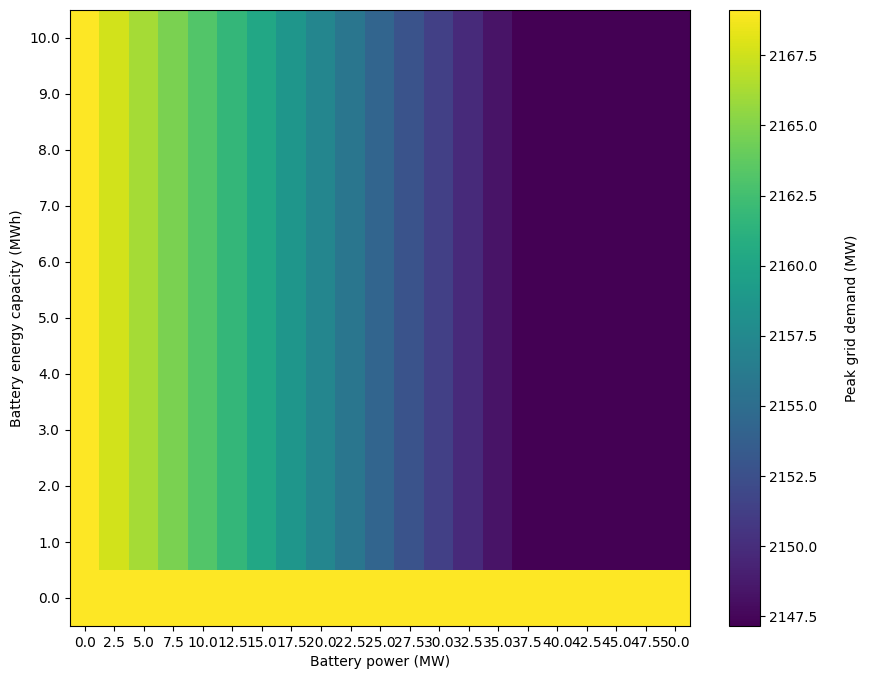

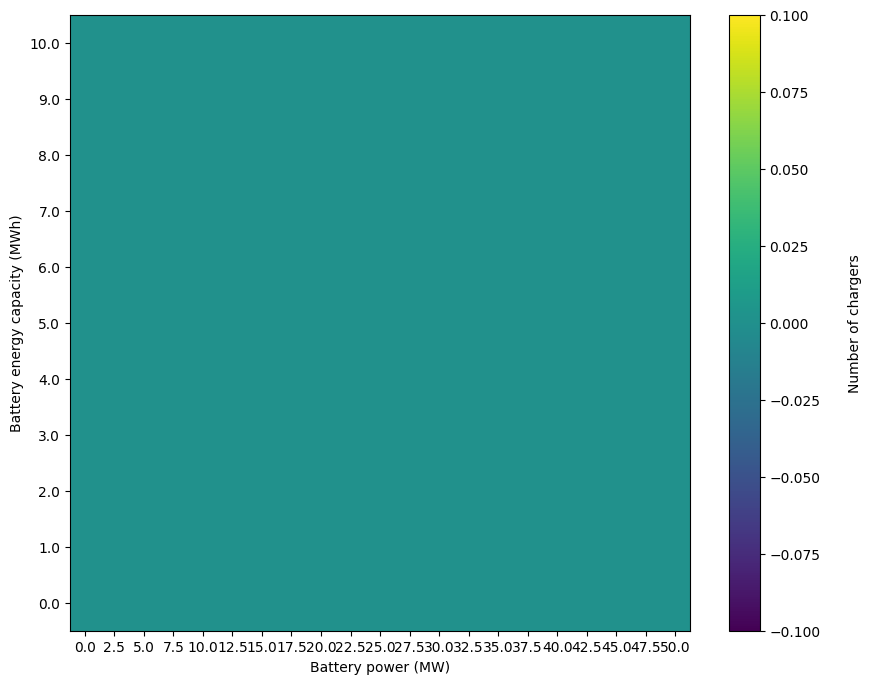

In [53]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
im = plt.pcolor(scan_battery_peak_demands)
plt.yticks(np.arange(0.5, len(scan_battery_peak_demands.index), 1), scan_battery_peak_demands.index)
plt.xticks(np.arange(0.5, len(scan_battery_peak_demands.columns), 1), scan_battery_peak_demands.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Peak grid demand (MW)", labelpad=20)#, rotation=270)

fig = plt.figure(figsize=(10, 30))
plt.subplot(3, 1, 1)
im = plt.pcolor(scan_battery_chargers_required_80)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_80.index), 1), scan_battery_chargers_required_80.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_80.columns), 1), scan_battery_chargers_required_80.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 80kW chargers", labelpad=20)#, rotation=270)
plt.subplot(3, 1, 2)
im = plt.pcolor(scan_battery_chargers_required_150)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_150.index), 1), scan_battery_chargers_required_150.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_150.columns), 1), scan_battery_chargers_required_150.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 150kW chargers", labelpad=20)#, rotation=270)
plt.subplot(3, 1, 3)
im = plt.pcolor(scan_battery_chargers_required_300)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_300.index), 1), scan_battery_chargers_required_300.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_300.columns), 1), scan_battery_chargers_required_300.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 300kW chargers", labelpad=20)#, rotation=270)

In [54]:

t1 = time.time()
scan_battery_peak_demands = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_300 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_150 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
scan_battery_chargers_required_80 = pd.DataFrame(index=batt_ps, columns=batt_cs, data = np.zeros([nu_battery_powers,nu_battery_capacities]))
Q = 10000
for batt_p in batt_ps:
    for batt_c in batt_cs:
        chargers = {'power': charger_power_array, 
                    'number': ["optim", "optim", "optim"], 
                    'cost': charger_cost_array}
        
        battery = {'power':batt_p*1000, 'capacity':batt_c*1000, 'efficiency':0.95, 'cost':10}

        problem = General_problem(trips_data, ec_total, bus, chargers, grid_limit=grid_limit, Q=Q, R=R, 
                            start_charge=START_CHARGE, final_charge=FINAL_CHARGE, deadhead=DEADHEAD,
                            resolution=RESOLUTION, min_charge_time=MIN_CHARGE_TIME, 
                            reserve=RESERVE, battery=battery, num_buses=num_buses_scans,
                            windows=off_peak)
        
        results = problem.solve()
        
        scan_battery_peak_demands.loc[batt_p, batt_c] = float(results['grid_limit'])
        scan_battery_chargers_required_80.loc[batt_p, batt_c] = float(chargers['number'][0])
        scan_battery_chargers_required_150.loc[batt_p, batt_c] = float(chargers['number'][1])
        scan_battery_chargers_required_300.loc[batt_p, batt_c] = float(chargers['number'][2])

print(scan_battery_peak_demands)
print(scan_battery_chargers_required)
t2 = time.time()
print('Solve took {} seconds'.format(t2 - t1))

           0.0        2.5        5.0        7.5        10.0       12.5  \
0.0   4158.7726  4158.7726  4158.7726  4158.7726  4158.7726  4158.7726   
1.0   4158.7726  3790.2381  3500.3243  3356.7467  3349.2303  3346.4030   
2.0   4158.7726  3790.2381  3421.7036  3053.1691  2841.8760  2637.1347   
3.0   4158.7726  3790.2381  3421.7036  3053.1691  2684.6347  2510.1299   
4.0   4158.7726  3790.2381  3421.7036  3053.1691  2684.6347  2510.1299   
5.0   4158.7726  3790.2381  3421.7036  3053.1691  2684.6347  2510.1299   
6.0   4158.7726  3790.2381  3421.7036  3053.1691  2684.6347  2510.1299   
7.0   4158.7726  3790.2381  3421.7036  3053.1691  2684.6347  2510.1299   
8.0   4158.7726  3790.2381  3421.7036  3053.1691  2684.6347  2510.1299   
9.0   4158.7726  3790.2381  3421.7036  3053.1691  2684.6347  2510.1299   
10.0  4158.7726  3790.2381  3421.7036  3053.1691  2684.6347  2510.1299   

           15.0       17.5       20.0       22.5  ...       27.5       30.0  \
0.0   4158.7726  4158.7726  4158

Text(0, 0.5, 'Number of chargers')

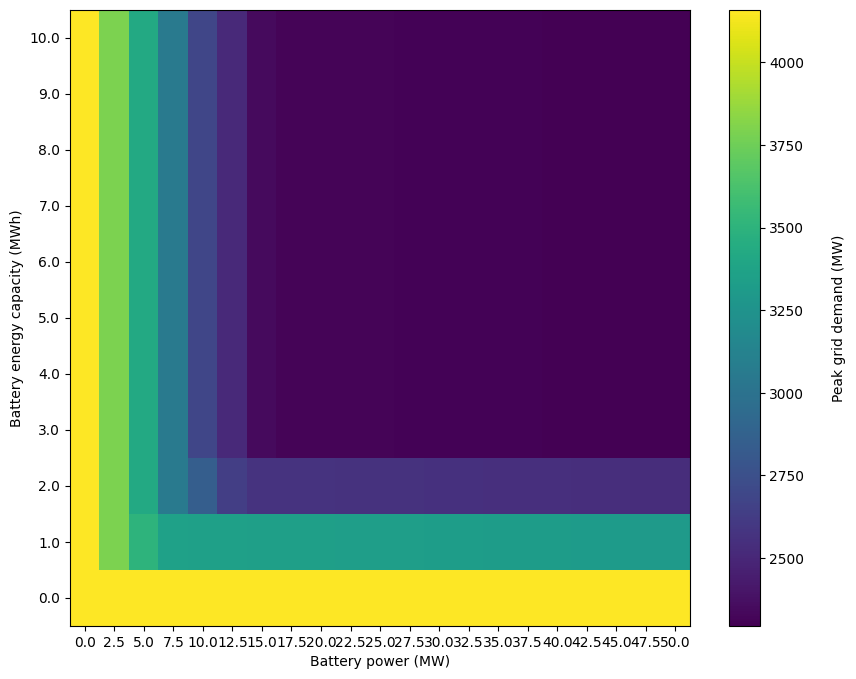

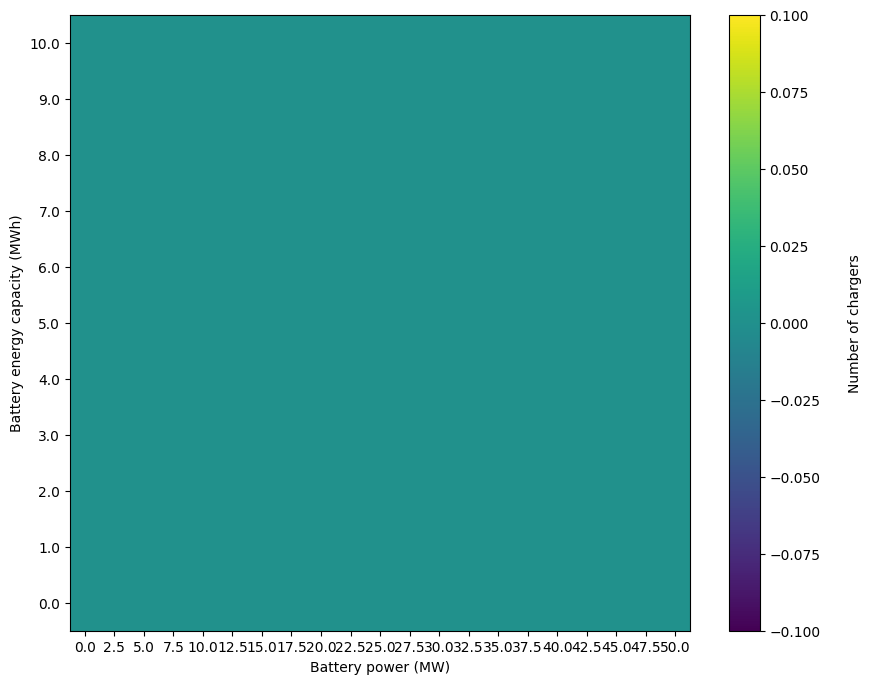

In [55]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1)
im = plt.pcolor(scan_battery_peak_demands)
plt.yticks(np.arange(0.5, len(scan_battery_peak_demands.index), 1), scan_battery_peak_demands.index)
plt.xticks(np.arange(0.5, len(scan_battery_peak_demands.columns), 1), scan_battery_peak_demands.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Peak grid demand (MW)", labelpad=20)#, rotation=270)

fig = plt.figure(figsize=(10, 30))
plt.subplot(3, 1, 1)
im = plt.pcolor(scan_battery_chargers_required_80)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_80.index), 1), scan_battery_chargers_required_80.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_80.columns), 1), scan_battery_chargers_required_80.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 80kW chargers", labelpad=20)#, rotation=270)
plt.subplot(3, 1, 2)
im = plt.pcolor(scan_battery_chargers_required_150)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_150.index), 1), scan_battery_chargers_required_150.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_150.columns), 1), scan_battery_chargers_required_150.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 150kW chargers", labelpad=20)#, rotation=270)
plt.subplot(3, 1, 3)
im = plt.pcolor(scan_battery_chargers_required_300)
plt.yticks(np.arange(0.5, len(scan_battery_chargers_required_300.index), 1), scan_battery_chargers_required_300.index)
plt.xticks(np.arange(0.5, len(scan_battery_chargers_required_300.columns), 1), scan_battery_chargers_required_300.columns)
plt.xlabel("Battery power (MW)")
plt.ylabel("Battery energy capacity (MWh)")
cbar = fig.colorbar(im)
cbar.ax.set_ylabel(r"Number of 300kW chargers", labelpad=20)#, rotation=270)